In [1]:
"""
Model
"""
import os
from multiprocessing import Queue
import csv
import pickle
import math
import argparse
import itertools
import numpy as np
import cv2
import json
import tensorflow as tf
from keras.layers.core import Lambda
from keras.models import Sequential, load_model
from keras.layers import Dense, Input, Activation, Dropout, Conv2D, Flatten, MaxPooling2D, Convolution2D
from keras.layers.advanced_activations import ELU
from keras.optimizers import SGD, Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_DIR = 'data/'
LABELS_FILENAME = os.path.join(DATA_DIR,'driving_log.csv')
NUM_THREADS = 8
dataQueue = Queue()


"""
Functions for training
"""
# generate training data in an infinite loop - passed into keras fit_generator
def genTrainingData(gray):
    data = dataQueue.get()
    print("Generator data size: %d" % len(data))
    while True:
        data = shuffle(data)
        src = genNormalizedData(genAugmentedViews(data), gray)
        for sample in src:
            yield sample

def genValidationData(data):
    while True:
        for row in data:
            yield (readImage(row['center']), float(row['steering']))

# enumerate rows of csv data - returns raw row contents
def enumDrivingLog(driving_log_fname):
    with open(driving_log_fname, 'r') as labels_file:
        rdr=csv.DictReader(labels_file)
        for row in rdr:
            yield row

# filter out some rows (based on keepPercentage) with low steering values (based on threshold)
def filterDrivingLog(src, threshold, keepPercentage):
    for row in src:
        steering = float(row['steering'])
        if abs(steering) > threshold or np.random.randint(0,100) <= keepPercentage:
            yield row

def genShadowsOnView(src):
    for img, steering in src:
        # add random shadows to center, right and left cameras
        yield (addShadow(img), steering)
        yield (addShadow(img), steering)

def genDimmerViews(src):
    for img, steering in src:
        # vary image brightness on each camera - to half and third of the original brightness
        yield (adjustBrightness(img, .75), steering)
        yield (adjustBrightness(img, .5), steering)
        yield (adjustBrightness(img, .25), steering)

def genShiftedViews(src):
    for img, steering in src:
        # add random shifts
        yield addShift(img, steering, axis=0)
        yield addShift(img, steering, axis=1)
        # flip center camera image
        yield (cv2.flip(img, 1), steering * -1.)
            
# generate images that supplement the data set
def genAugmentedViews(src):
    for row in src:
        steering = float(row['steering'])
        center = readImage(row['center'])
        left = readImage(row['left'])
        right = readImage(row['right'])
        
        imgSrcArr = []
        # center camera image
        imgSrcArr.append( (center, steering) )

        # adjust steering for left and right cameras
        left_steer = np.clip(steering + 0.1, -1, 1)
        right_steer = np.clip(steering - 0.1, -1, 1)
        imgSrcArr.append( (left, left_steer) )
        imgSrcArr.append( (right, right_steer) )

        for item in imgSrcArr:
            yield item
        for txItem in genShiftedViews(imgSrcArr):
            yield txItem
        for txItem in genDimmerViews(imgSrcArr):
            yield txItem
        for txItem in genShadowsOnView(imgSrcArr):
            yield txItem
        for txItem in genShadowsOnView(genShiftedViews(imgSrcArr)):
            yield txItem
        

# shift image horizontally by a random number of pixels and proportionally adjust steering angle
# axis 1 for horizontal, 0 for vertical
def addShift(img, steering, axis):
     
    # pick random shift amount between -1/5th width to +1/5th width
    amt = int(np.random.randint(-img.shape[axis]//5,img.shape[axis]//5+1))
    # destination image that will contain shifted image
    sImg = np.zeros(img.shape,dtype=np.uint8)
    if axis == 1:
        # compute change in steering
        steer_inc = -amt / img.shape[axis]
        #print("Steering: %.3f, Inc: %.3f" %(steering, steer_inc))
        steering += steer_inc
        # shift image by copying part of image into destination
        if amt < 0:
            amt = abs(amt)
            sImg[:,amt:img.shape[axis]] = img[:,0:img.shape[axis]-amt]
        else:
            sImg[:,0:img.shape[axis]-amt] = img[:,amt:img.shape[axis]]
    else:
        # shift image by copying part of image into destination
        if amt < 0:
            amt = abs(amt)
            sImg[amt:img.shape[axis],:] = img[0:img.shape[axis]-amt,:]
        else:
            sImg[0:img.shape[axis]-amt,:] = img[amt:img.shape[axis],:]
    # return new image and steering pair
    return sImg,steering

# adds a random shadow to a given image
def addShadow(img):
    # pick a random shadow coloration
    shadow_shade = np.random.randint(60,120)
    # convert image to YUV space to get the luma (brightness) channel
    y,u,v = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb))
    y = y.astype(np.int32)
    # create mask image with same shape as input image
    #mask = np.zeros(y.shape, dtype=np.int32)
    # compute a random line in slope, intercept form
    # random x1,x2 values (y1=0, y2=height)
    x1 = np.random.uniform() * y.shape[1]
    x2 = np.random.uniform() * y.shape[1]
    slope = float(y.shape[0]) / (x2 - x1)
    intercept = -(slope * x1)
    # assign pixels of mask below line
    for j in range(y.shape[0]):
        for i in range(y.shape[1]):
            if j > (i*slope)+intercept:
                y[j,i] -= shadow_shade
    # apply mask
    #y += mask
    # ensure values are within uint8 range to avoid artifacts
    y = np.clip(y, 0,255).astype(np.uint8)
    # convert back to RGB
    return cv2.cvtColor(cv2.merge((y,u,v)), cv2.COLOR_YCrCb2RGB)

# adjust brightness of given image (img) by multiplyling V (brightness)
def adjustBrightness(img, m):
    h,s,v = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2HSV))
    v = np.clip(v * m, 0, 255).astype(np.uint8)
    return cv2.cvtColor(cv2.merge((h,s,v)), cv2.COLOR_HSV2RGB)

# normalize image and steering data
# round out steering values to fall in 0.01 buckets (so problem is simplified, could even become classification problem)
# keras requires np.array for y values: convert steering to 1D np.array
def genNormalizedData(src, gray):
    for img,steering in src:
        # round steering values
        normSteering = round(steering,2)
        x = normalizeImage(img, gray)
        y = np.array(normSteering, ndmin=1, dtype=np.float)
        yield x,y

"""
Operations done for every image - both training and predictions
"""
# retrive image data from disk
# returns image in RGB format
def readImage(img_fname):
    img_path = os.path.join(DATA_DIR,img_fname.strip())
    img = cv2.imread(img_path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# convert RGB to YUV
def convColorSpace2YUV(img):
    y,u,v = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb))
    return cv2.merge((y,u,v))

# convert RGB to gray (keep 3rd dim as 1)
def convColorSpace2Gray(img):
    y,u,v = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb))
    return y.reshape(*y.shape,1)

# crop 5th off top and 25px off bottom of given image
def cropImage(img):
    ht = img.shape[0]
    cropHt = ht // 5
    return img[cropHt:ht-25, :]

# normalize image data
# convert to y,u,v or gray (keep only y)
# crop to remove top 5th and bottom 5th of image
# keras requires 4d-tensor input: add dimension 1, h,w,d for image data
def normalizeImage(img, gray):
    croppedImg = cropImage(img)
    resizedImg = cv2.resize(croppedImg, (200,66), interpolation = cv2.INTER_CUBIC)
    if gray:
        yuvImg = convColorSpace2Gray(resizedImg)
    else:
        yuvImg = convColorSpace2YUV(resizedImg)
    return yuvImg.reshape(1,*yuvImg.shape).astype(np.float32)

# de-normalize image data to RGB format for display
def imgForDisplay(img):
    img = img.astype(np.uint8)
    img = img.reshape(img.shape[1:4])
    if img.shape[2] == 3: #yuv
        img = cv2.cvtColor(img, cv2.COLOR_YCrCb2RGB)
    elif img.shape[2] == 1: #grayscale
        img = img.reshape(img.shape[0:2])
    return img





No. Original Images: 4729 No. Augmented Images Per Original: 45, Total Samples: 212805, Shape of sample:(1, 66, 200, 3)


/home/anand/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


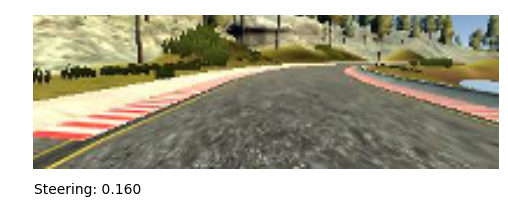

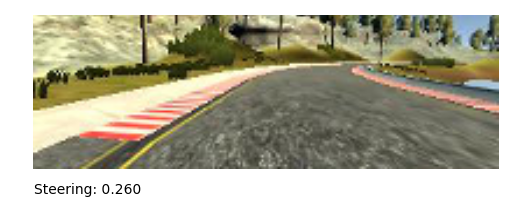

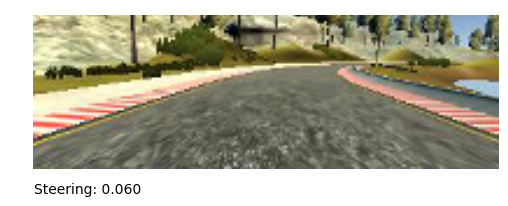

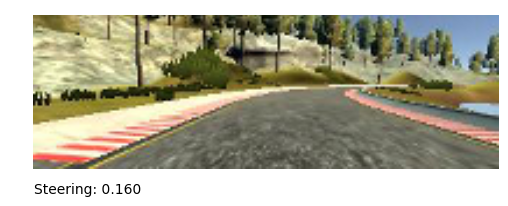

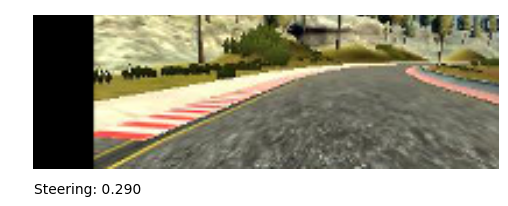

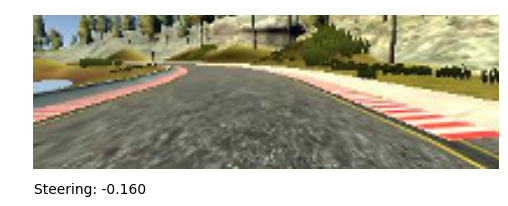

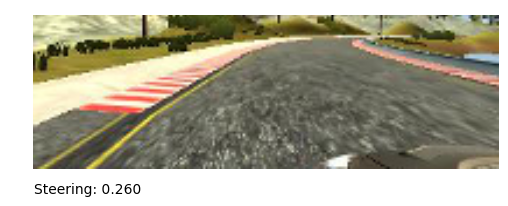

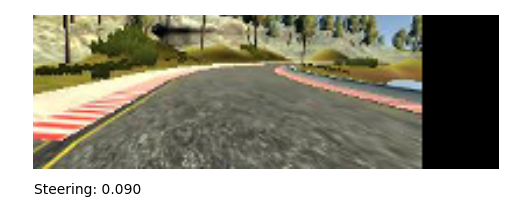

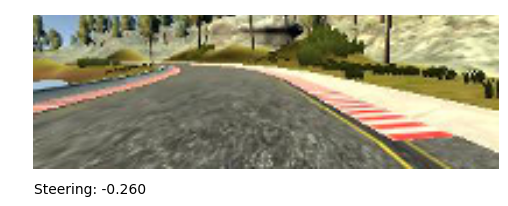

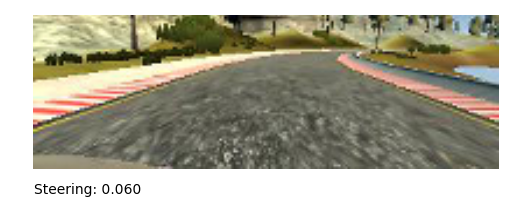

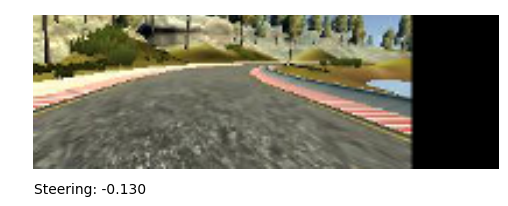

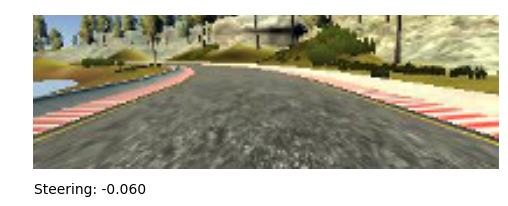

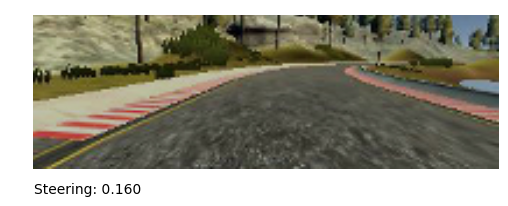

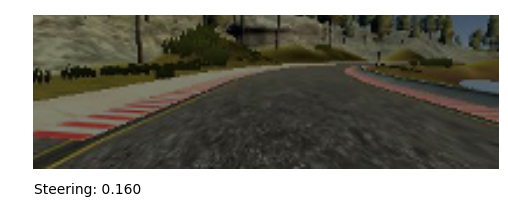

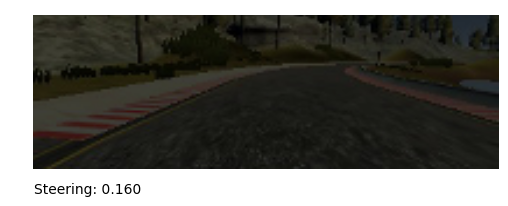

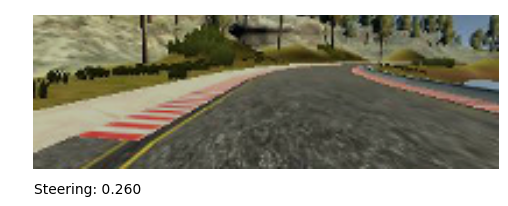

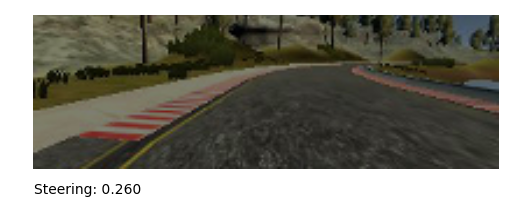

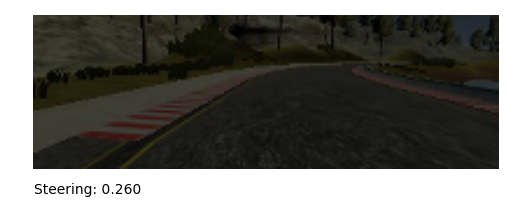

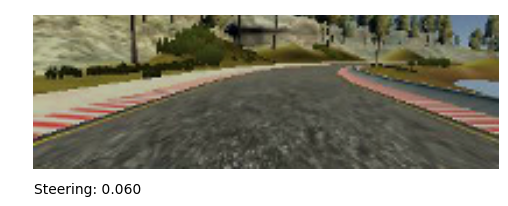

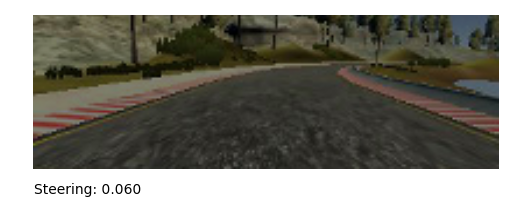

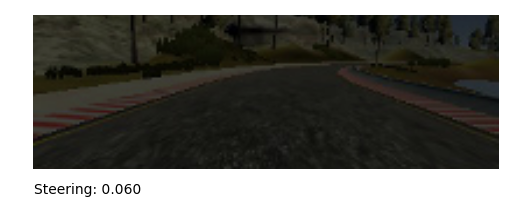

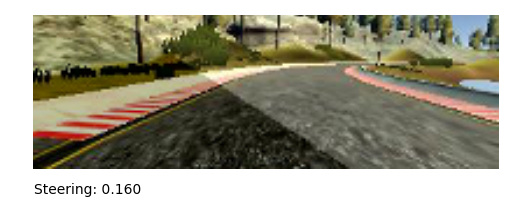

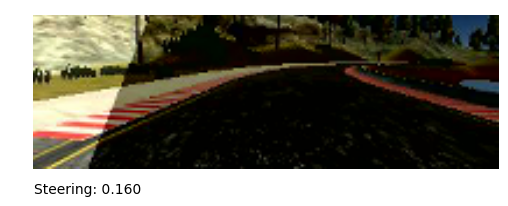

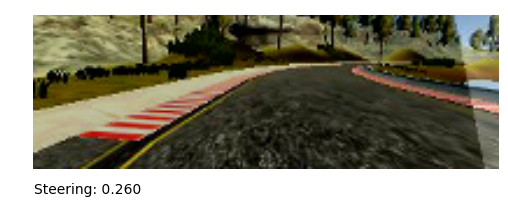

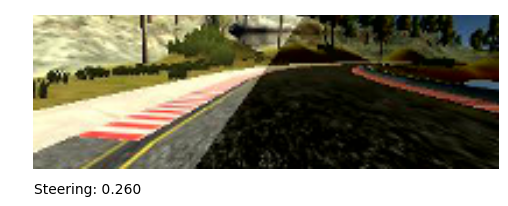

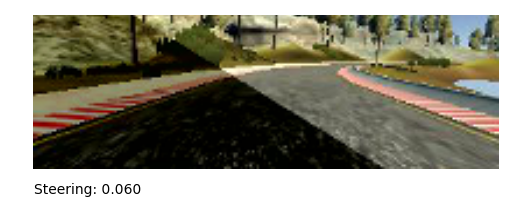

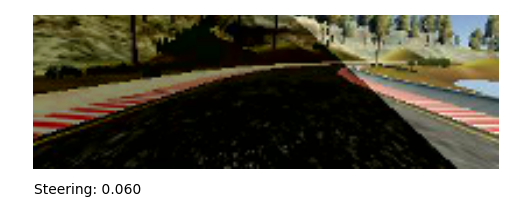

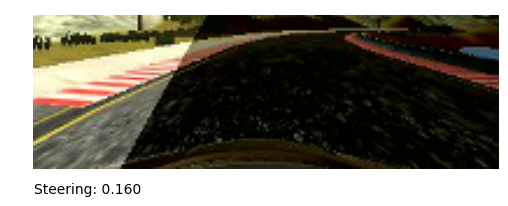

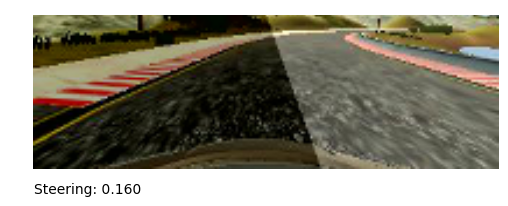

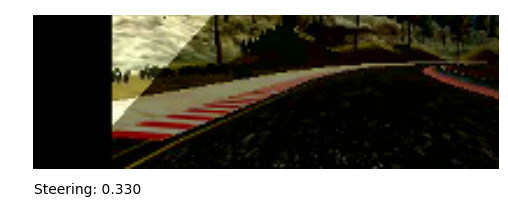

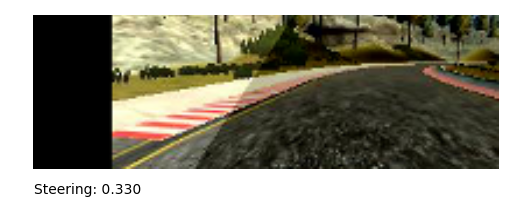

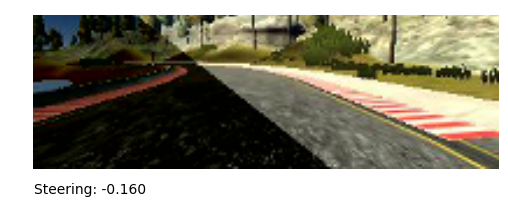

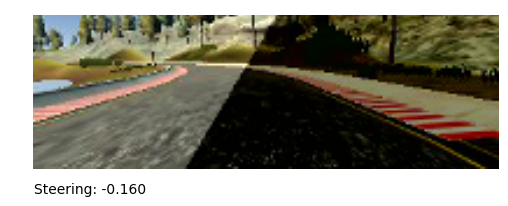

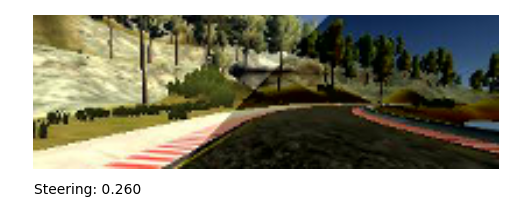

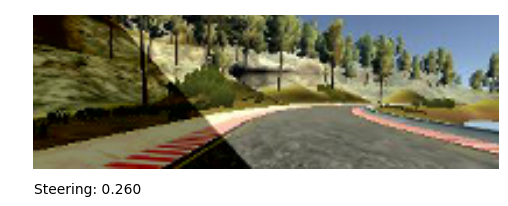

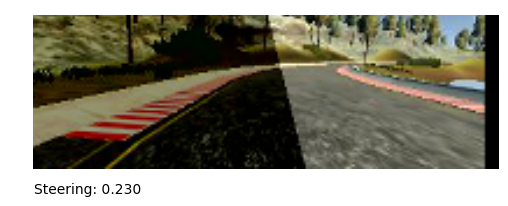

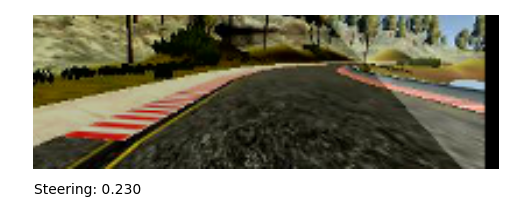

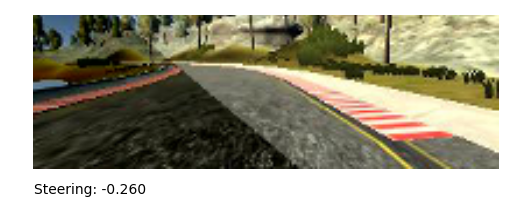

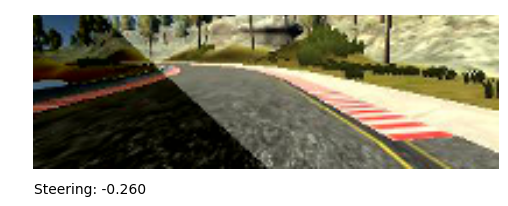

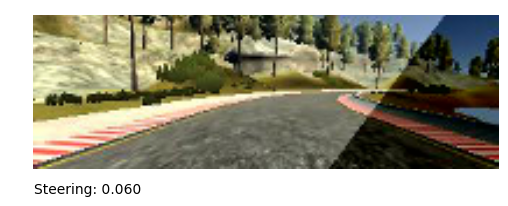

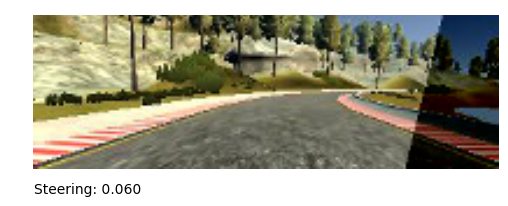

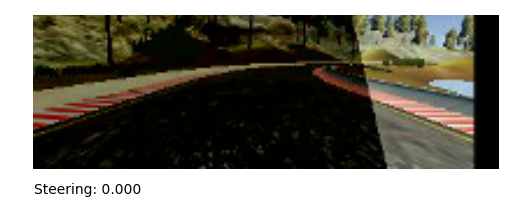

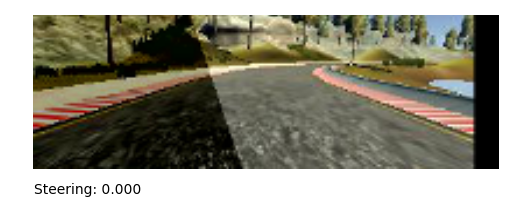

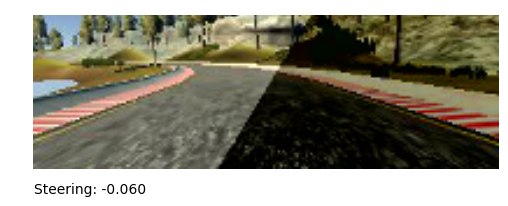

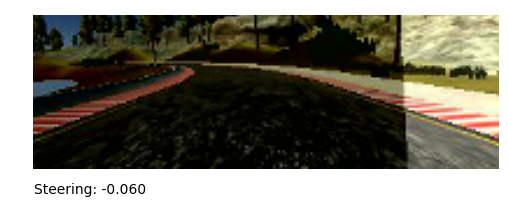

In [3]:
data = list(filterDrivingLog(enumDrivingLog(LABELS_FILENAME), 0.01, 25))

train = shuffle(data)

# select a row that has non-zero steering angle to be used for visualization and computing
# image dimensions and samples per image created by augmentation
sampleIdx = 0
while float(train[sampleIdx]['steering']) == 0.:
    sampleIdx += 1

# wrap selected row with data augmentation generators
imageGenerator = genNormalizedData(genAugmentedViews([train[sampleIdx]]), False)
imgListExample = list(imageGenerator)
numImagesPerSample = len(imgListExample)
numRows = len(train) * numImagesPerSample
exampleImg = imgListExample[0][0]

# get image dimensions
image_shape = exampleImg.shape
print("No. Original Images: {0} No. Augmented Images Per Original: {1}, Total Samples: {2}, Shape of sample:{3}".format(len(train), numImagesPerSample, numRows, image_shape))


# Visualization of selected - to ensure augmented images are correct
for normImg,normSteering in imgListExample:
    plt.figure()
    plt.axis('off')
    img = imgForDisplay(normImg)
    ht = img.shape[0]+10
    steering = normSteering # * 2.
    if len(img.shape) == 3: # rgb
        plt.imshow(img)
    else: # grayscale
        plt.imshow(img, cmap='gray')
    plt.text(0,ht,'Steering: %.3f' % steering)

